Все логи обучения в code.ipynb

# Import and misc

In [1]:
!pip install torch==1.10.0
!pip install torchaudio==0.10.0
!pip install thop

In [2]:
from typing import Tuple, Union, List, Callable, Optional
from tqdm import tqdm
from itertools import islice
import pathlib
import dataclasses

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torch import nn
from torch import distributions
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence

import torchaudio
from IPython import display as display_


torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Task

In this notebook we will implement a model for finding a keyword in a stream.

We will implement the version with CRNN because it is easy and improves the model. 
(from https://www.dropbox.com/s/22ah2ba7dug6pzw/KWS_Attention.pdf)

In [3]:
@dataclasses.dataclass
class TaskConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 256
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 20
    n_mels: int = 40
    cnn_out_channels: int = 8
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 64
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')

# Data

In [4]:
!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz -O speech_commands_v0.01.tar.gz
!mkdir speech_commands && tar -C speech_commands -xvzf speech_commands_v0.01.tar.gz 1> log

--2021-11-22 15:38:41--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.218.128, 2a00:1450:4013:c08::80
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.218.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G   103MB/s    in 16s     

2021-11-22 15:38:58 (88.5 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]



In [5]:
class SpeechCommandDataset(Dataset):

    def __init__(
        self,
        transform: Optional[Callable] = None,
        path2dir: str = None,
        keywords: Union[str, List[str]] = None,
        csv: Optional[pd.DataFrame] = None
    ):        
        self.transform = transform

        if csv is None:
            path2dir = pathlib.Path(path2dir)
            keywords = keywords if isinstance(keywords, list) else [keywords]
            
            all_keywords = [
                p.stem for p in path2dir.glob('*')
                if p.is_dir() and not p.stem.startswith('_')
            ]

            triplets = []
            for keyword in all_keywords:
                paths = (path2dir / keyword).rglob('*.wav')
                if keyword in keywords:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 1))
                else:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 0))
            
            self.csv = pd.DataFrame(
                triplets,
                columns=['path', 'keyword', 'label']
            )

        else:
            self.csv = csv
    
    def __getitem__(self, index: int):
        instance = self.csv.iloc[index]

        path2wav = instance['path']
        wav, sr = torchaudio.load(path2wav)
        wav = wav.sum(dim=0)
        
        if self.transform:
            wav = self.transform(wav)

        return {
            'wav': wav,
            'keywors': instance['keyword'],
            'label': instance['label']
        }

    def __len__(self):
        return len(self.csv)

In [6]:
dataset = SpeechCommandDataset(
    path2dir='speech_commands', keywords=TaskConfig.keyword
)

In [7]:
dataset.csv.sample(5)

,path,keyword,label
50042,speech_commands/one/bfaf2000_nohash_0.wav,one,0
50175,speech_commands/one/569455ff_nohash_0.wav,one,0
54676,speech_commands/go/6c968bd9_nohash_3.wav,go,0
3579,speech_commands/bird/e82914c0_nohash_0.wav,bird,0
54151,speech_commands/go/c2aeb59d_nohash_0.wav,go,0


### Augmentations

In [8]:
class AugsCreation:

    def __init__(self):
        self.background_noises = [
            'speech_commands/_background_noise_/white_noise.wav',
            'speech_commands/_background_noise_/dude_miaowing.wav',
            'speech_commands/_background_noise_/doing_the_dishes.wav',
            'speech_commands/_background_noise_/exercise_bike.wav',
            'speech_commands/_background_noise_/pink_noise.wav',
            'speech_commands/_background_noise_/running_tap.wav'
        ]

        self.noises = [
            torchaudio.load(p)[0].squeeze()
            for p in self.background_noises
        ]

    def add_rand_noise(self, audio):

        # randomly choose noise
        noise_num = torch.randint(low=0, high=len(
            self.background_noises), size=(1,)).item()
        noise = self.noises[noise_num]

        noise_level = torch.Tensor([1])  # [0, 40]

        noise_energy = torch.norm(noise)
        audio_energy = torch.norm(audio)
        alpha = (audio_energy / noise_energy) * \
            torch.pow(10, -noise_level / 20)

        start = torch.randint(
            low=0,
            high=max(int(noise.size(0) - audio.size(0) - 1), 1),
            size=(1,)
        ).item()
        noise_sample = noise[start: start + audio.size(0)]

        audio_new = audio + alpha * noise_sample
        audio_new.clamp_(-1, 1)
        return audio_new

    def __call__(self, wav):
        aug_num = torch.randint(low=0, high=4, size=(1,)).item()   # choose 1 random aug from augs
        augs = [
            lambda x: x,
            lambda x: (x + distributions.Normal(0, 0.01).sample(x.size())).clamp_(-1, 1),
            lambda x: torchaudio.transforms.Vol(.25)(x),
            lambda x: self.add_rand_noise(x)
        ]

        return augs[aug_num](wav)

In [9]:
indexes = torch.randperm(len(dataset))
train_indexes = indexes[:int(len(dataset) * 0.8)]
val_indexes = indexes[int(len(dataset) * 0.8):]

train_df = dataset.csv.iloc[train_indexes].reset_index(drop=True)
val_df = dataset.csv.iloc[val_indexes].reset_index(drop=True)

In [10]:
# Sample is a dict of utt, word and label
train_set = SpeechCommandDataset(csv=train_df, transform=AugsCreation())
val_set = SpeechCommandDataset(csv=val_df)

### Sampler for oversampling:

In [11]:
# We should provide to WeightedRandomSampler _weight for every sample_; by default it is 1/len(target)

def get_sampler(target):
    class_sample_count = np.array(
        [len(np.where(target == t)[0]) for t in np.unique(target)])   # for every class count it's number of occ.
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in target])
    samples_weight = torch.from_numpy(samples_weight)
    samples_weigth = samples_weight.float()
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    return sampler

In [12]:
train_sampler = get_sampler(train_set.csv['label'].values)

In [13]:
class Collator:
    
    def __call__(self, data):
        wavs = []
        labels = []    

        for el in data:
            wavs.append(el['wav'])
            labels.append(el['label'])

        # torch.nn.utils.rnn.pad_sequence takes list(Tensors) and returns padded (with 0.0) Tensor
        wavs = pad_sequence(wavs, batch_first=True)    
        labels = torch.Tensor(labels).long()
        return wavs, labels

###  Dataloaders

In [14]:
# Here we are obliged to use shuffle=False because of our sampler with randomness inside.

train_loader = DataLoader(train_set, batch_size=TaskConfig.batch_size,
                          shuffle=False, collate_fn=Collator(),
                          sampler=train_sampler,
                          num_workers=2, pin_memory=True)

val_loader = DataLoader(val_set, batch_size=TaskConfig.batch_size,
                        shuffle=False, collate_fn=Collator(),
                        num_workers=2, pin_memory=True)

### Creating MelSpecs on GPU for speeeed: 

In [15]:
class LogMelspec:

    def __init__(self, is_train, config):
        # with augmentations
        if is_train:
            self.melspec = nn.Sequential(
                torchaudio.transforms.MelSpectrogram(
                    sample_rate=config.sample_rate,
                    n_fft=400,
                    win_length=400,
                    hop_length=160,
                    n_mels=config.n_mels
                ),
                torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
                torchaudio.transforms.TimeMasking(time_mask_param=35),
            ).to(config.device)

        # no augmentations
        else:
            self.melspec = torchaudio.transforms.MelSpectrogram(
                sample_rate=config.sample_rate,
                n_fft=400,
                win_length=400,
                hop_length=160,
                n_mels=config.n_mels
            ).to(config.device)

    def __call__(self, batch):
        # already on device
        return torch.log(self.melspec(batch).clamp_(min=1e-9, max=1e9))

In [16]:
melspec_train = LogMelspec(is_train=True, config=TaskConfig)
melspec_val = LogMelspec(is_train=False, config=TaskConfig)

### Quality measurment functions:

In [17]:
# FA - true: 0, model: 1
# FR - true: 1, model: 0

def count_FA_FR(preds, labels):
    FA = torch.sum(preds[labels == 0])
    FR = torch.sum(labels[preds == 0])
    
    # torch.numel - returns total number of elements in tensor
    return FA.item() / torch.numel(preds), FR.item() / torch.numel(preds)

In [18]:
def get_au_fa_fr(probs, labels):
    sorted_probs, _ = torch.sort(probs)
    sorted_probs = torch.cat((torch.Tensor([0]), sorted_probs, torch.Tensor([1])))
    labels = torch.cat(labels, dim=0)
        
    FAs, FRs = [], []
    for prob in sorted_probs:
        preds = (probs >= prob) * 1
        FA, FR = count_FA_FR(preds, labels)        
        FAs.append(FA)
        FRs.append(FR)
    # plt.plot(FAs, FRs)
    # plt.show()

    # ~ area under curve using trapezoidal rule
    return -np.trapz(FRs, x=FAs)

# Model

In [19]:
class Attention(nn.Module):

    def __init__(self, hidden_size: int):
        super().__init__()

        self.energy = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, input):
        energy = self.energy(input)
        alpha = torch.softmax(energy, dim=-2)
        return (input * alpha).sum(dim=-2)

class CRNN(nn.Module):

    def __init__(self, config: TaskConfig):
        super().__init__()
        self.config = config

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = Attention(config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)
    
    def forward(self, input):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        return output

config = TaskConfig()
model = CRNN(config)
model

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)

In [20]:
def train_epoch(model, opt, loader, log_melspec, device):
    model.train()
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        # run model # with autocast():
        logits = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(logits, dim=-1)
        loss = F.cross_entropy(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc

In [21]:
@torch.no_grad()
def validation(model, loader, log_melspec, device):
    model.eval()

    val_losses, accs, FAs, FRs = [], [], [], []
    all_probs, all_labels = [], []
    for i, (batch, labels) in tqdm(enumerate(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        output = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(output, dim=-1)
        loss = F.cross_entropy(output, labels)

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        all_probs.append(probs[:, 1].cpu())
        all_labels.append(labels.cpu())
        val_losses.append(loss.item())
        accs.append(
            torch.sum(argmax_probs == labels).item() /  # ???
            torch.numel(argmax_probs)
        )
        FA, FR = count_FA_FR(argmax_probs, labels)
        FAs.append(FA)
        FRs.append(FR)

    # area under FA/FR curve for whole loader
    au_fa_fr = get_au_fa_fr(torch.cat(all_probs, dim=0).cpu(), all_labels)
    return au_fa_fr

In [22]:
from collections import defaultdict
from IPython.display import clear_output
from matplotlib import pyplot as plt

history = defaultdict(list)

In [23]:
from thop import profile  # !pip install thop

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Conv1d(1, 1, 3, bias=False)
    
    def forward(self, x):
        return self.model(x)
        
profile(CRNN(config).to(config.device), (torch.randn(128, 40, 101).to(config.device), ))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.


(119527424.0, 70443.0)

In [24]:
import tempfile

def get_size_in_kilobytes(model, label=""):
    # https://pytorch.org/tutorials/recipes/recipes/dynamic_quantization.html#look-at-model-size
    with tempfile.TemporaryFile() as f:
        torch.save(model.state_dict(), f)
        size = f.tell() / 2**10
        print("model: ",label,' \t','Size (KB):', size)
    return size

# Dark Knowledge Distilation

In [25]:
!gdown --id 1TMDjzv-73MDL2lt6Lypv2w-mjOScroFK

Downloading...
From: https://drive.google.com/uc?id=1TMDjzv-73MDL2lt6Lypv2w-mjOScroFK
To: /content/checkpoint_dla_basemodel
100% 285k/285k [00:00<00:00, 46.3MB/s]


In [26]:
model.load_state_dict(torch.load('checkpoint_dla_basemodel'))
model = model.to(config.device)

In [27]:
def train_epoch_distillated(model, opt, loader, log_melspec, device, trained_model, alpha=0.5, T=4):
    model.train()
    trained_model.eval()
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        logits = model(batch)
        with torch.no_grad():
            teacher_preds = trained_model(batch) / T
            teacher_probs = F.softmax(teacher_preds, dim=-1)
        probs = F.softmax(logits, dim=-1)
        loss = T**2 * alpha * F.cross_entropy(logits / T, teacher_probs)
        loss += (1 - alpha) * F.cross_entropy(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc

In [28]:
history = defaultdict(list)

In [29]:
config = TaskConfig(cnn_out_channels=3, hidden_size=16, gru_num_layers=2, kernel_size=(3, 10), num_epochs=110)
dark_knowledge_model = CRNN(config).to(config.device)

print(dark_knowledge_model)

opt = torch.optim.Adam(
    dark_knowledge_model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 3, kernel_size=(3, 10), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(57, 16, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=16, out_features=16, bias=True)
      (1): Tanh()
      (2): Linear(in_features=16, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=16, out_features=2, bias=True)
)


In [30]:
profile(CRNN(TaskConfig()).to(config.device), (torch.randn(128, 40, 101).to(config.device), ))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.


(119527424.0, 70443.0)

In [31]:
profile(CRNN(config).to(config.device), (torch.randn(128, 40, 101).to(config.device), ))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.


(11516416.0, 5648.0)

In [34]:
!gdown --id 1pn9bU6AtY-oFDRgOO7l5NfuuVZaA_NfQ

Downloading...
From: https://drive.google.com/uc?id=1pn9bU6AtY-oFDRgOO7l5NfuuVZaA_NfQ
To: /content/checkpoint_dla_distillated
100% 26.1k/26.1k [00:00<00:00, 21.2MB/s]


In [35]:
dark_knowledge_model.load_state_dict(torch.load('checkpoint_dla_distillated'))
dark_knowledge_model = dark_knowledge_model.to(config.device)

# Quantization

### Creating MelSpecs on CPU for not using nightly releasy with ability to quantize on CUDA: 

In [36]:
config = TaskConfig(device=torch.device('cpu'))

In [37]:
melspec_train = LogMelspec(is_train=True, config=config)
melspec_val = LogMelspec(is_train=False, config=config)

### Dynamic quantization int8 for GRU + Linear (coz Convs are not supported for dynamic)

In [38]:
model_int8 = torch.quantization.quantize_dynamic(
    model.to('cpu'),  # the original model
    {nn.GRU, nn.Linear},  # a set of layers to dynamically quantize
    dtype=torch.qint8)  # the target dtype for quantized weights

In [39]:
validation(model_int8, val_loader,
           melspec_val, config.device)

51it [00:10,  5.03it/s]


1.682251663118214e-05

In [40]:
print('The size of the model in KB has decreased by {} times'.format(
    get_size_in_kilobytes(model, label='base') / get_size_in_kilobytes(model_int8, label='dynamically quantized')))

model:  base  	 Size (KB): 279.5517578125
model:  dynamically quantized  	 Size (KB): 80.7841796875
The size of the model in KB has decreased by 3.4604765301065 times


### Dynamic quantization float16 for GRU + Linear (coz Convs are not supported for dynamic)

In [41]:
model_float16 = torch.quantization.quantize_dynamic(
    model.to('cpu'),  # the original model
    {nn.GRU, nn.Linear},  # a set of layers to dynamically quantize
    dtype=torch.float16)  # the target dtype for quantized weights

In [42]:
validation(model_float16, val_loader,
           melspec_val, config.device)

51it [00:09,  5.47it/s]


1.5891579208527146e-05

In [43]:
print('The size of the model in KB has decreased by {} times'.format(
    get_size_in_kilobytes(model, label='base') / get_size_in_kilobytes(model_float16, label='dynamically quantized')))

model:  base  	 Size (KB): 279.5517578125
model:  dynamically quantized  	 Size (KB): 282.1591796875
The size of the model in KB has decreased by 0.9907590393554171 times


# Dynamic quantization int8 for GRU + Linear (coz Convs are not supported for dynamic) after distillation

In [44]:
config = TaskConfig(device=torch.device('cpu'))

In [45]:
distillated_model_int8 = torch.quantization.quantize_dynamic(
    dark_knowledge_model.to('cpu'),  # the original model
    {nn.GRU, nn.Linear},  # a set of layers to dynamically quantize
    dtype=torch.qint8)  # the target dtype for quantized weights

In [46]:
validation(distillated_model_int8, val_loader,
           melspec_val, config.device)

51it [00:09,  5.64it/s]


3.215314636708384e-05

### Comparison with distillated model

In [47]:
print('The size of the model in KB has decreased by {} times compared to distillated model'.format(
    get_size_in_kilobytes(dark_knowledge_model, label='distillated') / get_size_in_kilobytes(distillated_model_int8, label='distillated and dynamically quantized')))

model:  distillated  	 Size (KB): 26.4892578125
model:  distillated and dynamically quantized  	 Size (KB): 13.5966796875
The size of the model in KB has decreased by 1.9482151835093011 times compared to distillated model


### Comparison with base model

In [48]:
print('The size of the model in KB has decreased by {} times compared to base model'.format(
    get_size_in_kilobytes(model, label='base') / get_size_in_kilobytes(distillated_model_int8, label='distillated and dynamically quantized')))

model:  base  	 Size (KB): 279.5517578125
model:  distillated and dynamically quantized  	 Size (KB): 13.5966796875
The size of the model in KB has decreased by 20.56029591323709 times compared to base model


# Dynamic quantization float16 for GRU + Linear (coz Convs are not supported for dynamic) after distillation

I have no clue what's going on here. Honestly, it should takes less memory but seems that some extra quantizatation tools inside model are taking too much memory or extra information about layers. Or maybe bug...

In [49]:
config = TaskConfig(device=torch.device('cpu'))

In [50]:
distillated_model_float16 = torch.quantization.quantize_dynamic(
    dark_knowledge_model.to('cpu'),  # the original model
    {nn.GRU, nn.Linear},  # a set of layers to dynamically quantize
    dtype=torch.float16)  # the target dtype for quantized weights

In [51]:
validation(distillated_model_float16, val_loader,
           melspec_val, config.device)

51it [00:09,  5.58it/s]


3.097157194602174e-05

In [52]:
dark_knowledge_model

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 3, kernel_size=(3, 10), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(57, 16, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=16, out_features=16, bias=True)
      (1): Tanh()
      (2): Linear(in_features=16, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=16, out_features=2, bias=True)
)

In [53]:
distillated_model_float16

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 3, kernel_size=(3, 10), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): DynamicQuantizedGRU(57, 16, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): DynamicQuantizedLinear(in_features=16, out_features=16, dtype=torch.float16)
      (1): Tanh()
      (2): DynamicQuantizedLinear(in_features=16, out_features=1, dtype=torch.float16)
    )
  )
  (classifier): DynamicQuantizedLinear(in_features=16, out_features=2, dtype=torch.float16)
)

### Comparison with distillated model

In [54]:
print('The size of the model in KB has decreased by {} times compared to distillated model'.format(
    get_size_in_kilobytes(dark_knowledge_model, label='distillated') / get_size_in_kilobytes(distillated_model_float16, label='distillated and dynamically quantized')))

model:  distillated  	 Size (KB): 26.4892578125
model:  distillated and dynamically quantized  	 Size (KB): 29.0966796875
The size of the model in KB has decreased by 0.910387648934385 times compared to distillated model


# Streaming

In [55]:
DEFAULT_MAX_WINDOW_LENGTH = 50
DEFAULT_STREAMING_STEP_SIZE = 20

class CRNNWithStreaming(CRNN):

    def __init__(self, config: TaskConfig):
        super().__init__(config)

        self.max_window_length = DEFAULT_MAX_WINDOW_LENGTH
        if hasattr(config, 'max_window_length'):
            self.max_window_length = max_window_length

        self.streaming_step_size = DEFAULT_STREAMING_STEP_SIZE
        if hasattr(config, 'streaming_step_size'):
            self.streaming_step_size = streaming_step_size

        self.gru_buffer = None
    
    def forward(self, input):
        if self.training:
            return super().forward(input)
        
        frame_pointer = self.max_window_length
        hidden = None
        outputs = None
        while frame_pointer < input.size(-1):
            frame = input[:, :, frame_pointer-self.max_window_length:frame_pointer].unsqueeze(dim=1)
            conv_output = self.conv(frame).transpose(-1, -2)
            gru_output, hidden = self.gru(conv_output, hidden)
            if self.gru_buffer is None:
                self.gru_buffer = gru_output
            else:
                self.gru_buffer = torch.cat((self.gru_buffer[:,-1:,:], gru_output), dim=1)
            contex_vector = self.attention(gru_output)
            output = self.classifier(contex_vector)
            if outputs is None:
                outputs = output.unsqueeze(0)
            else:
                outputs = torch.cat((outputs, output.unsqueeze(0)), dim=0)
            frame_pointer += self.streaming_step_size
            frame_pointer = min(frame_pointer, input.size(-1))
        return outputs


config = TaskConfig()

melspec_train = LogMelspec(is_train=True, config=config)
melspec_val = LogMelspec(is_train=False, config=config)

model_with_streaming = CRNNWithStreaming(config)
model_with_streaming.load_state_dict(torch.load('checkpoint_dla_basemodel'))
model_with_streaming = model_with_streaming.to(config.device)

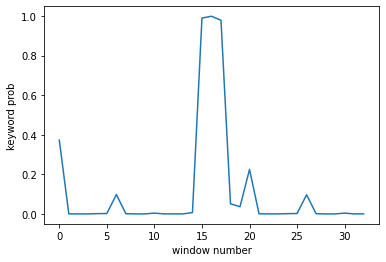

In [56]:
@torch.no_grad()
def streaming_plot(model, loader, log_melspec, device):
    model.eval()

    val_csv = val_set.csv
    not_kw_obj = val_csv[val_csv['label'] == 0]['path'].values
    not_kw = []
    for i in not_kw_obj:
        not_kw.append(str(i))
        if len(not_kw) == 3:
            break
    kw = str(val_csv[val_csv['label'] != 0]['path'].values[0])

    x = torch.cat([torchaudio.load(path)[0].squeeze() for path in (*not_kw, kw, *not_kw)]).to(device)
    x = log_melspec(x).unsqueeze(0)

    outputs = model(x)
    probs = F.softmax(outputs, dim=-1)

    plt.plot(list(range(probs.size(0))), probs[:, 0, 1].cpu())
    plt.xlabel('window number')
    plt.ylabel('keyword prob')
    plt.show()

streaming_plot(model_with_streaming, val_loader,
           melspec_val, config.device)